In [1]:
__author__ = 'Simon Mork <simonmorkofficial@gmail.com>, <simonmork@uchicago.edu>'
__version__ = '20230915' # yyyymmdd; version datestamp of this notebook
__keywords__ = ['extragalactic', 'galaxies', 'image cutout', 'Milky Way']
__datasets__ = ['ls_dr9']

# Locating Milky Way Analogues in Legacy Surveys Data

<i>Simon Mork, Department of Astronomy and Astrophysics, University of Chicago<i>

### Table of Contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimer & Attribution](#disclaimer)
* [Imports & Setup](#imports)
* [Data Access](#data)
* [Milky Way Analogue Selection](#analogues)
* [Image Cutout Generation](#cutouts)
* [Conclusion](#conclusion)
* [File Cleanup](#file_cleanup)
* [Resources and References](#references)

<a class='anchor' id='goals'></a>
# Goals
Using the photometric properties of the Milky Way as described in [Licquia & Newman 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract) [[1]](#references), we aim to scrape the Legacy Surveys Data Release 9 (LS DR9, [Dey et al. 2019](https://ui.adsabs.harvard.edu/abs/2019AJ....157..168D/abstract) [[2]](#references)) North catalog for possible Milky Way analogues. Similar studies have been performed on SDSS galaxies, but the Legacy Surveys provide much deeper imaging data. We also leverage the photometric redshift catalog created for LS DR9 in order to locate Milky Way analogues to higher redshifts than many SDSS-identified ones.

<a class='anchor' id='summary'></a>
# Summary

Milky-Way analogues are a unique class of objects that allow us to test photometric measurements of our own galaxy in an external environment. Additionally, studying the local environment of such analogues allows us to determine where the Milky Way fits into the evolutionary history of galaxies and the universe as a whole. In this notebook, we query Data Lab servers for photometric and morphological information from LS DR9 and match it to associated photometric redshift information. We then apply an initial filtering step to remove stars by selecting best fit Sersic, de Vaucouleurs, and exponential sources, as well as only selecting objects with valid dereddened photometry in all three photometric bandpasses (g,r,z). We then use the reported photometric redshifts to convert the observed magnitudes in each band into absolute magnitudes, factoring in appropriate K-corrections. We plot 2D histograms of our galaxy sample in color-magnitude and color-color space to verify that we have a reasonable sample of galaxies. We also scale the half light radius based on the appropriate angular diameter distance to convert to a physical distance at the redshift of a given galaxy. Finally we filter for Milky Way analogues with the appropriate size, absolute magnitude, and color within 1.5 sigma of the values provided in [Licquia & Newman 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract) [[1]](#references). We use a slightly larger error boundary than is reported in [Licquia & Newman 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract) [[1]](https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract) due to slight mismatches between the SDSS and DECam grz filters in the K-correction step. Finally, we save a cutout for a random subset of identified analogues from the Legacy Surveys viewer and plot them in a grid.

<a class='anchor' id='disclaimer'></a>
# Disclaimer & Attribution

If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., 'The NOAO Data Laboratory: a conceptual overview', SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445 
* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

This notebook makes use of the 'K-corrections calculator' at http://kcor.sai.msu.ru/.

This notebook was originally generated as part of the final project for ASTR 28500 "Science with Large Astronomical Surveys" at the University of Chicago.

<a class='anchor' id='imports'></a>
# Imports & Setup

In [2]:
import time
import urllib
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.cosmology import LambdaCDM
from tqdm import tqdm
from dl import queryClient as qc

mpl.rcParams['font.size'] = 20                  #changes the plot font size to 20
mpl.rcParams['font.family'] = 'serif'           #changes the font family to serif
mpl.rcParams['font.serif'] = ['cmr10']          #changes the font to Computer Modern Roman (dependent on the font family)
mpl.rcParams['mathtext.fontset'] = 'cm'         #changes the mathtype font to Computer Modern Roman
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['figure.figsize'] = [8,8]          #changes the figure dimensions to [width, height]
mpl.rcParams['figure.dpi'] = 120                #changes the figure dpi to [value]
plt.rc('axes', unicode_minus=False)             #makes negative signs plot correctly in CMR

cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

In [3]:
def calc_kcor(filter_name, redshift, colour_name, colour_value):
    '''
    K-corrections calculator in Python. See http://kcor.sai.msu.ru for the 
    reference. Available filter-colour combinations must be present in the 
    `coeff` dictionary keys.

    @type   filter_name: string    
    @param  filter_name: Name of the filter to calculate K-correction for, e.g. 
                         'u', 'g', 'r' for some of the SDSS filters, or 'J2', 
                         'H2', 'Ks2' for 2MASS filters (must be present in 
                         `coeff` dictionary)
    @type      redshift: float    
    @param     redshift: Redshift of a galaxy, should be between 0.0 and 0.5 (no
                         check is made, however)
    @type   colour_name: string    
    @param  colour_name: Human name of the colour, e.g. 'u - g', 'g - r', 
                         'V - Rc', 'J2 - Ks2' (must be present in `coeff` dictionary)
    @type  colour_value: float    
    @param colour_value: Value of the galaxy's colour, specified in colour_name    
    @rtype:              float
    @return:             K-correction in specified filter for given redshift and 
                         colour
    @version:            2012
    @author:             Chilingarian, I., Melchior. A.-L., and Zolotukhin, I.
    @license:            Simplified BSD license, see http://kcor.sai.msu.ru/license.txt

    Copyright 2009-2013 Chilingarian, I., Melchior. A.-L., and Zolotukhin, I. [3] [4] All rights reserved.
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.419.1727C/abstract
    https://ui.adsabs.harvard.edu/abs/2010MNRAS.405.1409C/abstract

    **Modified to only include the colors calculated in this notebook**
    
    Usage example:
    
        >>> calc_kcor('g', 0.2, 'g - r', 1.1)
        0.5209713975999992
        >>> calc_kcor('Ic', 0.4, 'V - Ic', 2.0)
        0.310069919999993
        >>> calc_kcor('H', 0.5, 'H - K', 0.1)
        -0.14983142499999502
        
    '''
    coeff = {

        'g_gr': [
            [0,0,0,0],
            [-2.45204,4.10188,10.5258,-13.5889],
            [56.7969,-140.913,144.572,57.2155],
            [-466.949,222.789,-917.46,-78.0591],
            [2906.77,1500.8,1689.97,30.889],
            [-10453.7,-4419.56,-1011.01,0],
            [17568,3236.68,0,0],
            [-10820.7,0,0,0],
        ],

        'r_gr': [
            [0,0,0,0],
            [1.83285,-2.71446,4.97336,-3.66864],
            [-19.7595,10.5033,18.8196,6.07785],
            [33.6059,-120.713,-49.299,0],
            [144.371,216.453,0,0],
            [-295.39,0,0,0],
        ],

        'z_rz': [
            [0,0,0,0],
            [0.669031,-3.08016,9.87081,-7.07135],
            [-18.6165,8.24314,-14.2716,13.8663],
            [94.1113,11.2971,-11.9588,0],
            [-225.428,-17.8509,0,0],
            [197.505,0,0,0],
        ],

    }

    c = coeff[filter_name + '_' + colour_name.replace(' - ', '')]
    kcor = 0.0

    for x, a in enumerate(c):
        for y, b in enumerate(c[x]):
            kcor += c[x][y] * redshift**x * colour_value**y

    return kcor

<a class='anchor' id='data'></a>
# Data Access

Here we query the LS DR9 catalog for relevant photometric and morphological data along with photometric redshifts. Since we are limited by the maximum runtime of a query, we query in chunks and then concatenate them together.

Change the following values to adjust for your use case:
* `RAMIN` and `RAMAX` correspond to the lower and upper bounds in RA for the search area respectively.
* `RACHUNKS` corresponds to the number of RA bins for the Data Lab query loop.
* `DECMIN` and `DECMAX` correspond to the lower and upper bounds in Dec for the search area respectively.
* `DECCHUNKS` corresponds to the number of Dec bins for the Data Lab query loop.

Example:

```
RAMIN, RAMAX, RACHUNKS = 90, 120, 3
DECMIN, DECMAX, DECCHUNKS = 40, 70, 3
```

This would select objects in a range from RA=90 to RA=120 and Dec=40 to Dec=70 using nine square chunks in a 3x3 arrangement with each chunk side length equal to 10 degrees. It takes about 4 minutes to run (if the servers aren't too busy).

In [4]:
RAMIN, RAMAX, RACHUNKS = 90, 120, 3
DECMIN, DECMAX, DECCHUNKS = 40, 70, 3

In [5]:
query = '''
SELECT t.ra, t.dec, t.type, t.dered_mag_g, t.dered_mag_r, t.dered_mag_z,
       t.shape_e1, t.shape_e2, t.shape_r, p.z_phot_mean
FROM ls_dr9.tractor as t
JOIN ls_dr9.photo_z as p
ON t.ls_id = p.ls_id
WHERE p.z_phot_mean BETWEEN 0 AND 0.1
      AND t.ra BETWEEN {} AND {}
      AND t.dec BETWEEN {} AND {}
'''

dfs = []
ra_width = (RAMAX-RAMIN)/RACHUNKS
dec_width = (DECMAX-DECMIN)/DECCHUNKS
for ra in np.linspace(RAMIN, RAMIN+ra_width*(RACHUNKS-1), RACHUNKS):
    for dec in np.linspace(DECMIN, DECMIN+dec_width*(DECCHUNKS-1), DECCHUNKS):
        t1 = time.time()
        q = query.format(ra, ra+ra_width, dec, dec+dec_width)
        response = qc.query(sql=q, fmt='pandas', timeout=600)
        dfs.append(response)
        print('FINISHED FOR RA %d-%d, DEC %d-%d AFTER %d s' % \
              (ra, ra+ra_width, dec, dec+dec_width, time.time()-t1))

FINISHED FOR RA 90-100, DEC 40-50 AFTER 27 s
FINISHED FOR RA 90-100, DEC 50-60 AFTER 32 s
FINISHED FOR RA 90-100, DEC 60-70 AFTER 24 s
FINISHED FOR RA 100-110, DEC 40-50 AFTER 38 s
FINISHED FOR RA 100-110, DEC 50-60 AFTER 26 s
FINISHED FOR RA 100-110, DEC 60-70 AFTER 18 s
FINISHED FOR RA 110-120, DEC 40-50 AFTER 24 s
FINISHED FOR RA 110-120, DEC 50-60 AFTER 23 s
FINISHED FOR RA 110-120, DEC 60-70 AFTER 19 s


In [6]:
df = pd.concat(dfs, axis=0)
df

,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_z,shape_e1,shape_e2,shape_r,z_phot_mean
0,98.407541,40.859433,PSF,18.002610,17.983746,19.006445,0.0,0.0,0.0000,0.002837
1,95.384679,46.950205,PSF,16.192099,18.314556,19.506830,0.0,0.0,0.0000,0.002689
2,96.342868,49.395205,PSF,17.420597,17.775137,18.756124,0.0,0.0,0.0000,0.002690
3,96.523112,48.083624,PSF,17.268068,18.262900,22.572159,0.0,0.0,0.0000,0.002849
4,96.962216,47.401485,PSF,16.524460,16.758266,19.313437,0.0,0.0,0.0000,0.002712
...,...,...,...,...,...,...,...,...,...,...
100111,117.213843,64.816234,PSF,18.072191,17.638975,17.507460,0.0,0.0,0.0000,0.099997
100112,116.490223,64.269033,PSF,22.038134,21.478000,21.519420,0.0,0.0,0.0000,0.099998
100113,119.653483,64.132940,REX,21.362326,21.085200,NaN,0.0,0.0,4.8208,0.099998
100114,118.748000,66.027267,PSF,19.156624,18.259226,17.810856,0.0,0.0,0.0000,0.099998


We filter to obtain only those sources which are robustly galaxies and also have valid (not null or inf) observations in all three bands.

In [7]:
nullfilter = (df['dered_mag_g'].notnull()) & (df['dered_mag_r'].notnull()) & (df['dered_mag_z'].notnull())
inf_filter = (~np.isinf(df['dered_mag_g'])) & (~np.isinf(df['dered_mag_r'])) & (~np.isinf(df['dered_mag_z']))
typefilter = (df['type']=='DEV') | (df['type']=='EXP') | (df['type']=='SER')
data = df[nullfilter & inf_filter & typefilter]

print(len(data), 'galaxies after quality cuts')

97082 galaxies after quality cuts


We apply relevant K-corrections to data and also scale the half-light radius by the appropriate angular diameter distance. We note that the K-corrections were derived for the SDSS bandpasses, which are slightly different than the DECam bandpasses. We account for this later on by broadening our selection region.

In [8]:
# Compute color terms for quality galaxies
g = data['dered_mag_g']
r = data['dered_mag_r']
z = data['dered_mag_z']
g_r = g - r
r_z = r - z

# Compute the ellipticity and aspect ratio (b/a) of the galaxy according to 
# https://www.legacysurvey.org/dr9/catalogs/#ellipticities
# for the optional projection filter
abs_e = np.sqrt(data['shape_e1']**2+data['shape_e2']**2)
a = (1-abs_e)/(1+abs_e)

# Load in the galaxy photometric redshifts, then convert the half-light radius from arcseconds, to radians, then to kiloparsecs
redshifts = np.asarray(data['z_phot_mean'])
half_light_rad = np.pi/180/60/60*data['shape_r']
half_light_kpc = cosmo.angular_diameter_distance(z=redshifts).value*1000*half_light_rad

# Convert observed magnitudes to absolute magnitudes factoring in the proper cosmological corrections 
cosmo_correction = cosmo.distmod(z=redshifts).value + 5*np.log10(cosmo.h)
M_g = g - calc_kcor('g', data['z_phot_mean'], 'g - r', g_r) - cosmo_correction
M_r = r - calc_kcor('r', data['z_phot_mean'], 'g - r', g_r) - cosmo_correction
M_z = z - calc_kcor('z', data['z_phot_mean'], 'r - z', r_z) - cosmo_correction

Color-magnitude and color-color plot for verification of galaxy population.

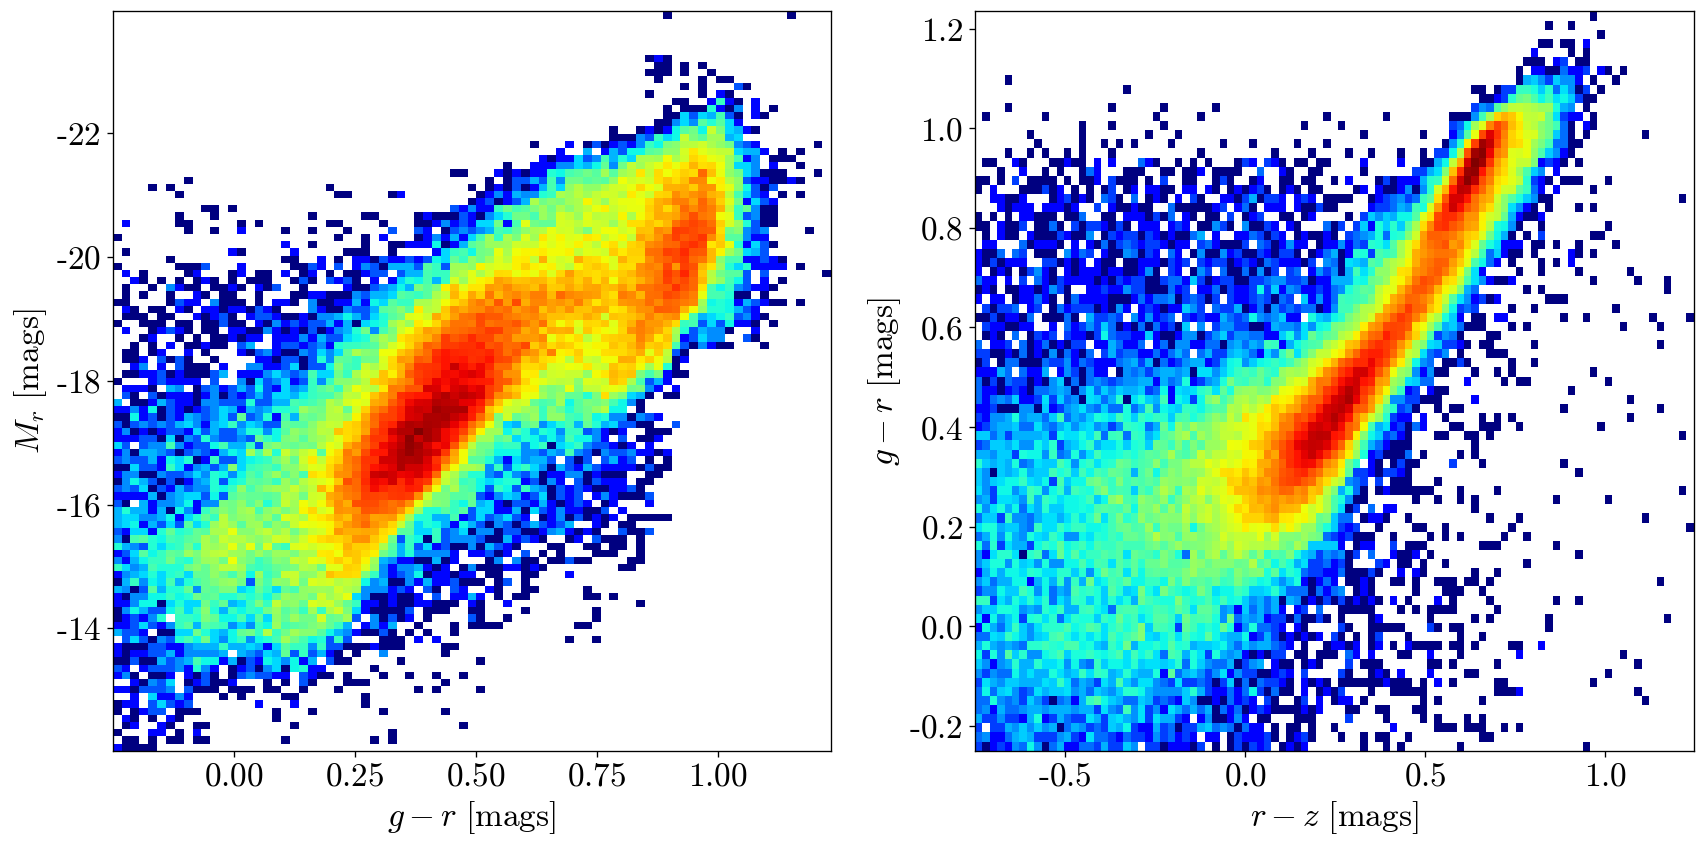

In [9]:
fig = plt.figure(figsize=(17,8), dpi=120)
axs = GridSpec(1, 2)
ax1, ax2 = fig.add_subplot(axs[0]), fig.add_subplot(axs[1])

colorcut = (g_r>-0.25) & (g_r<1.25) & (r_z>-0.75) & (r_z<1.25) & (M_r>-24) & (M_r<-12)
g_r_cut = g_r[colorcut]
r_z_cut = r_z[colorcut]
g_cut = g[colorcut]
r_cut = r[colorcut]
M_r_cut = M_r[colorcut]

g_r_bins, junk = np.histogram(g_r_cut, bins='auto')
r_z_bins, junk = np.histogram(r_z_cut, bins='auto')
g_bins, junk = np.histogram(g_cut, bins='auto')
r_bins, junk = np.histogram(g_cut, bins='auto')
M_r_bins, junk = np.histogram(M_r_cut, bins='auto')

ax1.hist2d(g_r_cut, M_r_cut, bins=[len(g_r_bins),len(M_r_bins)], cmap='jet', norm=LogNorm())
ax2.hist2d(r_z_cut, g_r_cut, bins=[len(r_z_bins),len(g_r_bins)], cmap='jet', norm=LogNorm())

ax1.set_xlabel(r'$g-r \ [\rm mags]$')
ax1.set_ylabel(r'$M_r \ [\rm mags]$')
ax1.invert_yaxis()
ax2.set_xlabel(r'$r-z \ [\rm mags]$')
ax2.set_ylabel(r'$g-r \ [\rm mags]$')
plt.show()

<a class='anchor' id='analogues'></a>
# Milky Way Analogue Selection

Below, we apply filters based on the best-fit values from [Licquia & Newman 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract) [[1]](#references) to identify Milky Way analogues.

In [10]:
# Measured values and upper/lower uncertainties
# [value, upper, lower]
# range = [value+upper, value-lower]

# MW size measurement from Licquia & Newman 2016 (https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract)
MW_rh_kpc = (4.4, 0.2, 0.2)

# MW absolute magnitude measurements and uncertainties from Table 7 of Licquia & Newman 2016 (https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract)
MW_M_g = (-20.33, 0.42, 0.43)
MW_M_r = (-20.97, 0.37, 0.40)
MW_M_z = (-21.53, 0.36, 0.39)

# MW color index from Table 7 of Licquia & Newman 2016 (https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract)
MW_g_r = (0.678, 0.069, 0.057)

In [11]:
# Broaden the selection region to account for the SDSS-based K-correction
sigma=1.5

half_light_filter = (half_light_kpc < MW_rh_kpc[0]+MW_rh_kpc[1]*sigma) & (half_light_kpc > MW_rh_kpc[0]-MW_rh_kpc[2]*sigma)
g_magnitude_filter = (M_g < MW_M_g[0]+MW_M_g[1]*sigma) & (M_g > MW_M_g[0]-MW_M_g[2]*sigma)
r_magnitude_filter = (M_r < MW_M_r[0]+MW_M_r[1]*sigma) & (M_r > MW_M_r[0]-MW_M_r[2]*sigma)
z_magnitude_filter = (M_z < MW_M_z[0]+MW_M_z[1]*sigma) & (M_z > MW_M_z[0]-MW_M_z[2]*sigma)
color_filter = (g_r < MW_g_r[0]+MW_g_r[1]*sigma) & (g_r > MW_g_r[0]-MW_g_r[2]*sigma)

#optional projection filter to include only relatively circular galaxies
projection_filter = a > 0.5

milkyway_filter = half_light_filter   & \
                  g_magnitude_filter  & \
                  r_magnitude_filter  & \
                  z_magnitude_filter  & \
                  color_filter        & \
                  projection_filter

mw_data = (data[milkyway_filter]).reset_index()
print(len(mw_data), 'Milky Way analogues found')

61 Milky Way analogues found


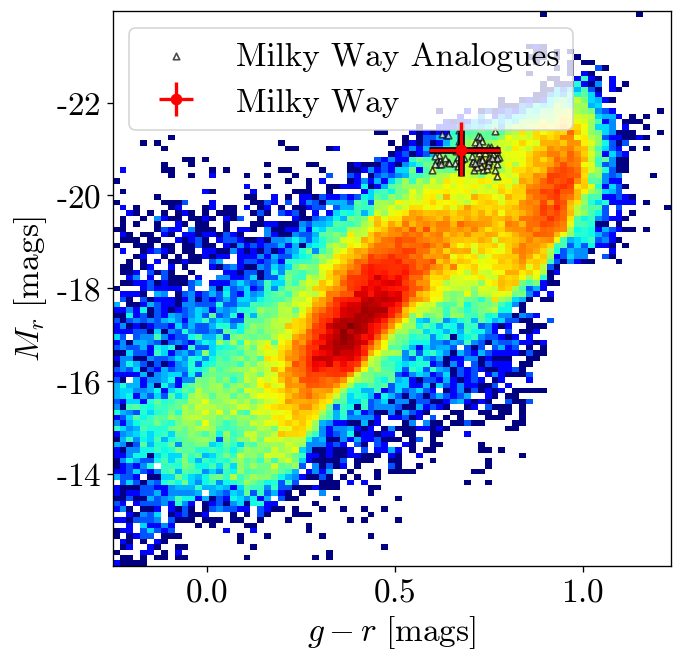

In [12]:
# Overplot the selected MW analogues and MW values on the previous color-magnitude histogram.
fig = plt.figure(figsize=(6,6), dpi=120)
plt.hist2d(g_r_cut, M_r_cut, bins=[len(g_r_bins), len(M_r_bins)], cmap='jet', norm=LogNorm())
plt.errorbar(MW_g_r[0], MW_M_r[0], 
             xerr=sigma*np.array([[MW_g_r[2], MW_g_r[1]]]).T, 
             yerr=sigma*np.array([[MW_M_r[2], MW_M_r[1]]]).T, 
             c='r', marker='o', ls='', capthick=2, elinewidth=2, zorder=10,
             label='Milky Way')
plt.errorbar(MW_g_r[0], MW_M_r[0], 
             xerr=sigma*np.array([[MW_g_r[2], MW_g_r[1]]]).T, 
             yerr=sigma*np.array([[MW_M_r[2], MW_M_r[1]]]).T, 
             c='k', marker='o', ls='', capthick=4, elinewidth=4, zorder=4)
plt.scatter(g_r[milkyway_filter], M_r[milkyway_filter],
            c='white', marker='^', s=15, alpha=0.7, edgecolors='black',
            label='Milky Way Analogues')

plt.legend(loc='upper left')
plt.gca().set_xlabel(r'$g-r \ [\rm mags]$')
plt.gca().set_ylabel(r'$M_r \ [\rm mags]$')
plt.gca().invert_yaxis()

<a class='anchor' id='cutouts'></a>
# Image Cutout Generation

Plotting code to generate a random subset of cutouts. This cell takes about a minute to run, depending on analogue sample size.

100%|██████████| 42/42 [00:33<00:00,  1.26it/s]


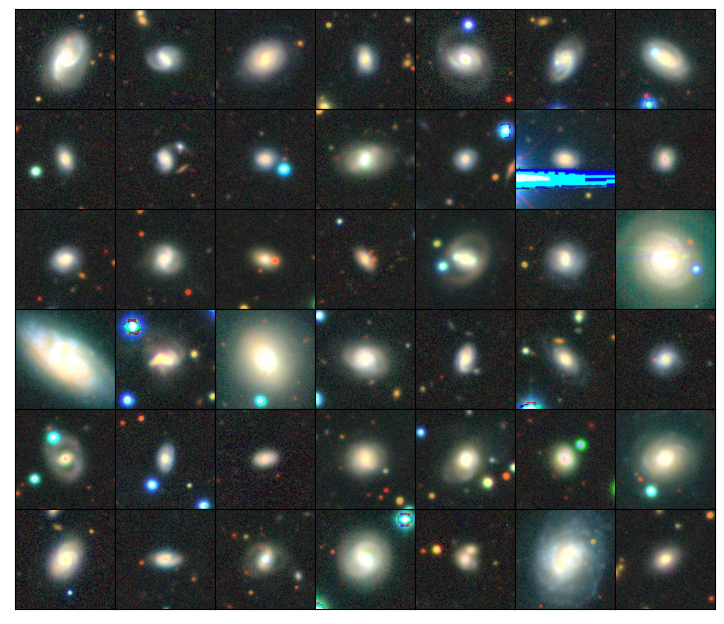

In [13]:
zoom = 2
nrow, ncol = int(np.floor(np.sqrt(len(mw_data))))-1, int(np.floor(np.sqrt(len(mw_data))))
fig = plt.figure(figsize=(ncol+1, nrow+1), dpi=100)
gs = GridSpec(nrow, ncol, wspace=0.0, hspace=0.0, \
                     top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), \
                     left=0.5/(ncol+1), right=1-0.5/(ncol+1))

indexes = []
for i in tqdm(np.random.choice(np.linspace(0, len(mw_data)-1, len(mw_data)), size=int(nrow*ncol), replace=False)):
    indexes.append(int(i))
    imgquery = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9&pixscale=0.262'
    urllib.request.urlretrieve(imgquery.format(mw_data['ra'][i], mw_data['dec'][i]), \
                               str(round(mw_data['ra'][i], 8))+'_'+str(round(mw_data['dec'][i], 8))+'.png')

counter=0
for row in range(nrow):
    for column in range(ncol):
        i = indexes[counter]; counter+=1
        ax = plt.subplot(gs[row,column])
        ax.set_xticks([]); ax.set_yticks([])
        tempim = np.asarray(Image.open(str(round(mw_data['ra'][i], 8))+'_'+str(round(mw_data['dec'][i], 8))+'.png'))
        ax.imshow(tempim[int(127-np.round(tempim.shape[0]/(zoom+1), 0)+1):int(127+np.round(tempim.shape[0]/(zoom+1), 0)),\
                  int(127-np.round(tempim.shape[0]/(zoom+1), 0)+1):int(127+np.round(tempim.shape[0]/(zoom+1), 0))])
plt.show()

It is interesting to see many spiral galaxies showing up in this sample, despite the fact that we did not put any morphological selection on galactic structure, only a projection filter (if implemented by the end user).

<a class='anchor' id='conclusion'></a>
# Conclusion

We have demonstrated that it is possible to identify galaxies that are similar to the Milky Way using photometric properties. Future steps for this project could include cross-checking photometric redshifts with known SDSS spectroscopic redshifts, as well as characterizing the color of the Milky Way in r-z as well (which is not provided in [Licquia & Newman 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract) [[1]](#references). It could also be interesting to perform a more detailed morphological analysis of the candidate analogues to better match the Milky Way morphology.

<a class='anchor' id='file_cleanup'></a>
# File Cleanup

To remove the generated cutout images from the notebook directory, un-comment the cell below and run it.

In [14]:
# !rm -f `pwd`/*png

<a class='anchor' id='references'></a>
# Resources and References

[[1]](https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract) Licquia, T. C. and Newman, J. A., “Sizing Up the Milky Way: A Bayesian Mixture Model Meta-analysis of Photometric Scale Length Measurements”, <i>The Astrophysical Journal</i>, vol. 831, no. 1, 2016. doi:10.3847/0004-637X/831/1/71

[[2]](https://ui.adsabs.harvard.edu/abs/2019AJ....157..168D/abstract) Dey, A., “Overview of the DESI Legacy Imaging Surdoi:10.3847/0004-637X/831/1/71veys”, <i>The Astronomical Journal</i>, vol. 157, no. 5, 2019. doi:10.3847/1538-3881/ab089d

[[3]](https://ui.adsabs.harvard.edu/abs/2012MNRAS.419.1727C/abstract) Chilingarian, I., Zolotukhin, I. 2012: A universal ultraviolet-optical colour-colour-magnitude relation of galaxies, MNRAS, v. 419, p. 1727 (also arXiv:1102.1159)

[[4]](https://ui.adsabs.harvard.edu/abs/2010MNRAS.405.1409C/abstract) Chilingarian, I., Melchior, A.-L., Zolotukhin, I. 2010: Analytical approximations of K-corrections in optical and near-infrared bands, MNRAS, v. 405, p. 1409 (also arXiv:1002.2360)